Lines 1 shape: (10, 10, 2) Lines 2 shape: (10, 10, 2)
After intersection - Lines 1 shape: 10 Lines 2 shape: 10


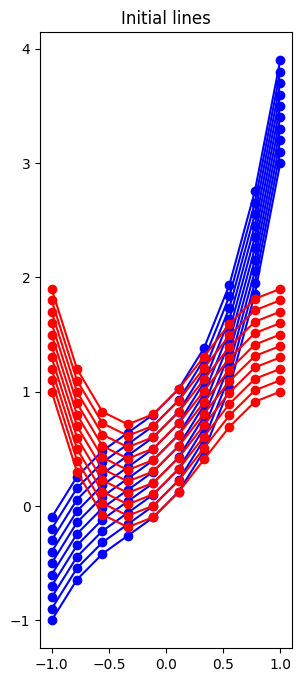

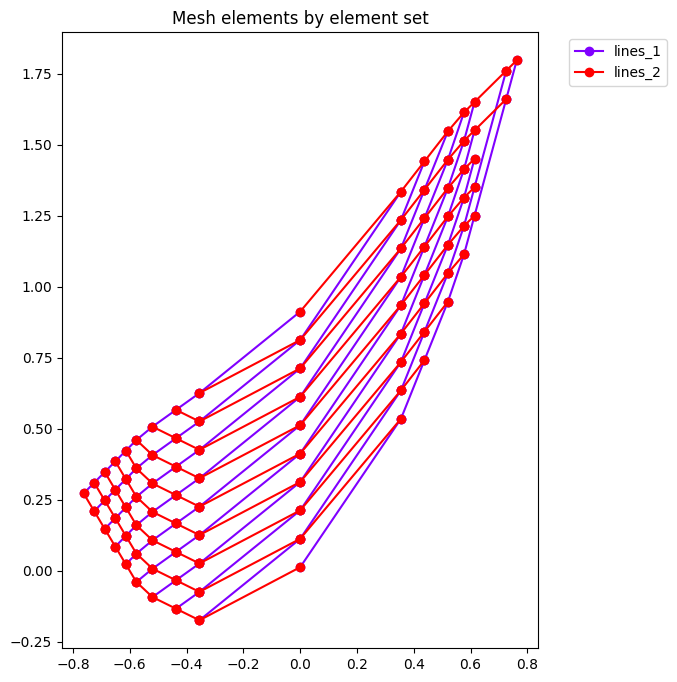

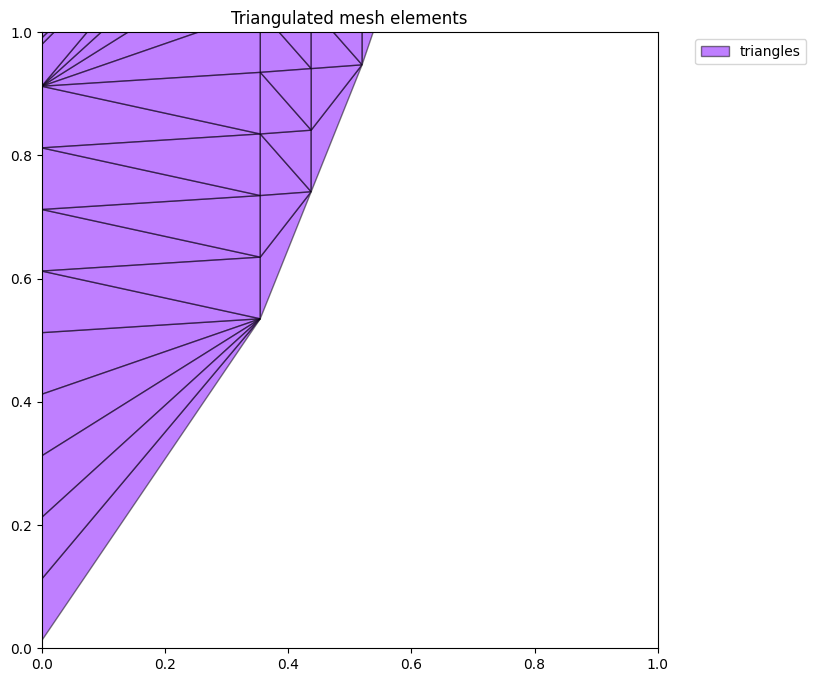

In [ ]:

from matplotlib import lines
import numpy as np
import Utils
from Tailoring import Lattice, Mesh, Set
import matplotlib.pyplot as plt
%matplotlib inline

### Edits made on 2024-06-10

# parabolas
def coord(x, sign, offset):
	return np.c_[x, sign*x**3 + x**2 + x + offset]

# lines
num_lines = 10
x = np.linspace(-1, 1, num_lines)
lines_1 = np.concatenate([coord(x, 1, offset/num_lines)[np.newaxis,...] for offset in range (num_lines)], axis=0)
lines_2 = np.concatenate([coord(x, -1, offset/num_lines)[np.newaxis,...] for offset in range (num_lines)], axis=0)
print("Lines 1 shape:", lines_1.shape, "Lines 2 shape:", lines_2.shape)

# plot: lines
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Initial lines")
ax.set_aspect('equal')
for line in lines_1:
    ax.plot(line[:,0], line[:,1], color='blue', marker='o')
for line in lines_2:
    ax.plot(line[:,0], line[:,1], color='red', marker='o')

# intersecting lines
lines_1, lines_2 = Lattice.resample_lines(lines_1, lines_2)
print("After intersection - Lines 1 shape:", len(lines_1), "Lines 2 shape:", len(lines_2))

# create mesh
mesh_2D = Mesh(2, 2)
mesh_2D.add_lines_to_mesh(lines_1, "lines_1")
mesh_2D.add_lines_to_mesh(lines_2, "lines_2")

# plot mesh: elements
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Mesh elements by element set")
ax.set_aspect('equal')
elsets = mesh_2D.elsets()
colours = plt.cm.rainbow(np.linspace(0,1,len(elsets)))
for (name, elset), colour in zip(elsets.items(), colours):
    for count, element in enumerate(elset):
        nodes = mesh_2D.elements[element]
        ax.plot(mesh_2D.nodes[nodes, 0], mesh_2D.nodes[nodes, 1], color=colour, marker='o', label=name if count==0 else None)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# triangulate mesh
mesh_2D_tri = Mesh(2,3)
for name, nset in mesh_2D.nsets().items():
    mesh_2D_tri.add_nodes(mesh_2D.nodes[nset], name)
mesh_2D_tri.triangulate(np.arange(mesh_2D_tri.nodes.shape[0]))

# plot mesh: elements
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title("Triangulated mesh elements")
ax.set_aspect('equal')
elsets = mesh_2D_tri.elsets()
colours = plt.cm.rainbow(np.linspace(0,1,len(elsets)))
for (name, elset), colour in zip(elsets.items(), colours):
    for count, element in enumerate(elset):
        nodes = mesh_2D_tri.elements[element]
        triangle = plt.Polygon(mesh_2D_tri.nodes[nodes], closed=True, facecolor=colour, edgecolor='k', alpha=0.5, label=name if count==0 else None)
        ax.add_patch(triangle)  
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# ax.set_xlim([-1.5, 1.5])
# ax.set_ylim([-0.5, 2.5])

